# Lab 4: Neural networks 

In this lab we will build dense neural networks on the MNIST dataset.

Make sure you read the tutorial for this lab first.

## Load the data and create train-test splits

In [1]:
# Global imports and settings
%matplotlib inline
import numpy as np
import pandas as pd
import openml as oml
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

/var/folders/0t/5d8ttqzd773fy0wq3h5db0xr0000gn/T/ipykernel_395/3841004139.py:3: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array');


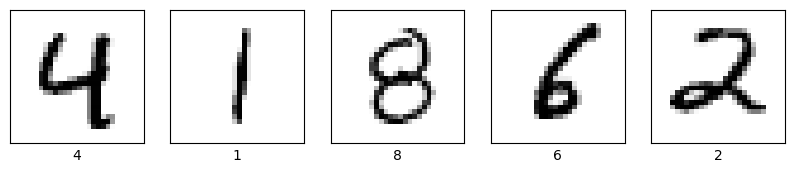

In [2]:
# Download MNIST data. Takes a while the first time.
mnist = oml.datasets.get_dataset(554)
X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array');
X = X.reshape(70000, 28, 28)

# Take some random examples
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X[n], cmap=plt.cm.gray_r)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("{}".format(y[n]))
plt.show();

## Exercise 1: Preprocessing
* Normalize the data: map each feature value from its current representation (an integer between 0 and 255) to a floating-point value between 0 and 1.0. 
* Create a train-test split using the first 60000 examples for training
* Flatten the data
* Convert the data (numpy arrays) to PyTorch tensors
* Create a TensorDataset for the training data, and another for the testing data

In [ ]:
# Solution
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Flatten images, create train-test split
X_flat = X.reshape(70000, 28 * 28)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, stratify=y)

# Convert numpy arrays to PyTorch tensors with correct types
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

## Exercise 2: Create a deep neural net model

Implement a `create_model` function which defines the topography of the deep neural net, specifying the following:

* The number of layers in the deep neural net: Use 2 dense layers for now (one hidden en one output layer)
* The number of nodes in each layer: these are parameters of your function.
* Any regularization layers. Add at least one dropout layer.

Consider:
* What should be the shape of the input layer?
* Which activation function you will need for the last layer, since this is a 10-class classification problem?

In [ ]:
### Create and compile a 'deep' neural net
def create_model(layer_1_units=32, layer_2_units=10, dropout_rate=0.3):
    pass

In [11]:
# Solution

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, layer_1_units=32, layer_2_units=10, dropout_rate=0.2):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, layer_1_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(layer_1_units, layer_2_units)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

def create_model(layer_1_units=32, layer_2_units=10, dropout_rate=0.3):
    model = SimpleNN(layer_1_units, layer_2_units, dropout_rate)
    return model       

## Exercise 3: Create a training function
Implement a `train_model` function which trains and evaluates a given model.
It should print out the train and validation loss and accuracy.

In [13]:
def train_model(model, train_dataset, val_dataset, epochs=10, batch_size=64, learning_rate=0.001):
    """
    model: the model to train
    train_dataset: the training data and labels
    test_dataset: the test data and labels
    epochs: the number of epochs to train for
    batch_size: the batch size for minibatch SGD
    learning_rate: the learning rate for the optimizer
    """
    pass


In [14]:
# Solution
import torch.optim as optim
import torchmetrics


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_dataset, val_dataset, epochs=10, batch_size=64, learning_rate=0.001):
    """
    Trains the model and returns the history (loss, accuracy, validation loss, validation accuracy).
    
    model: PyTorch model to be trained
    train_dataset: the training data and labels
    test_dataset: the test data and labels
    epochs: Number of training epochs
    batch_size: Batch size for training
    learning_rate: Learning rate for optimizer
    
    Returns:
    history: Dictionary containing training loss, accuracy, validation loss, and validation accuracy per epoch.
    """
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Loss function, optimizer, and accuracy metric
    criterion = nn.CrossEntropyLoss(label_smoothing=0.01)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=0.0)
    accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

    # Move model to device
    model.to(device)

    # Store history for plotting
    history = {"accuracy": [], "val_accuracy": [], "loss": [], "val_loss": []}

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass + loss calculation
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training metrics
            total_loss += loss.item()
            correct += accuracy_metric(outputs, y_batch).item() * y_batch.size(0)
            total += y_batch.size(0)

        # Compute epoch training metrics
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val)
                loss = criterion(val_outputs, y_val)

                val_loss += loss.item()
                val_correct += accuracy_metric(val_outputs, y_val).item() * y_val.size(0)
                val_total += y_val.size(0)

        val_avg_loss = val_loss / len(val_loader)
        val_avg_acc = val_correct / val_total

        # Store values in history
        history["accuracy"].append(train_acc)
        history["val_accuracy"].append(val_avg_acc)
        history["loss"].append(train_loss)
        history["val_loss"].append(val_avg_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Val Loss: {val_avg_loss:.4f}, Val Acc: {val_avg_acc:.4f}")

    return history  # Returning history for later plotting

## Exercise 4: Evaluate the model

Train the model with a learning rate of 0.003, 50 epochs, batch size 4000, and a validation set that is 20% of the total training data.

Use default settings otherwise. Plot the learning curve of the loss, validation loss, accuracy, and validation accuracy. Finally, report the performance on the test set.

Try to run the model on GPU.

Feel free to use the plotting function below, or implement the callback from the tutorial to see results in real time.

In [ ]:
# Helper plotting function
#
# history: the history object returned by the training function

def plot_curve(history):
    """
    Plots the learning curves for accuracy and loss.

    history: Dictionary containing 'accuracy', 'val_accuracy', 'loss', 'val_loss' per epoch.
    """
    epochs = range(1, len(history["accuracy"]) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["accuracy"], label="Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.show()

Epoch [1/10], Loss: 1.7313, Acc: 0.4590, Val Loss: 0.8359, Val Acc: 0.7502
Epoch [2/10], Loss: 0.9644, Acc: 0.6799, Val Loss: 0.5141, Val Acc: 0.8594
Epoch [3/10], Loss: 0.8192, Acc: 0.7405, Val Loss: 0.6168, Val Acc: 0.8269
Epoch [4/10], Loss: 0.7737, Acc: 0.7547, Val Loss: 0.5022, Val Acc: 0.8762
Epoch [5/10], Loss: 0.7424, Acc: 0.7661, Val Loss: 0.4150, Val Acc: 0.9079
Epoch [6/10], Loss: 0.7319, Acc: 0.7731, Val Loss: 0.4259, Val Acc: 0.9111
Epoch [7/10], Loss: 0.7189, Acc: 0.7797, Val Loss: 0.3873, Val Acc: 0.9218
Epoch [8/10], Loss: 0.6983, Acc: 0.7900, Val Loss: 0.4015, Val Acc: 0.9074
Epoch [9/10], Loss: 0.7019, Acc: 0.7897, Val Loss: 0.3757, Val Acc: 0.9209
Epoch [10/10], Loss: 0.7040, Acc: 0.7879, Val Loss: 0.4082, Val Acc: 0.9081


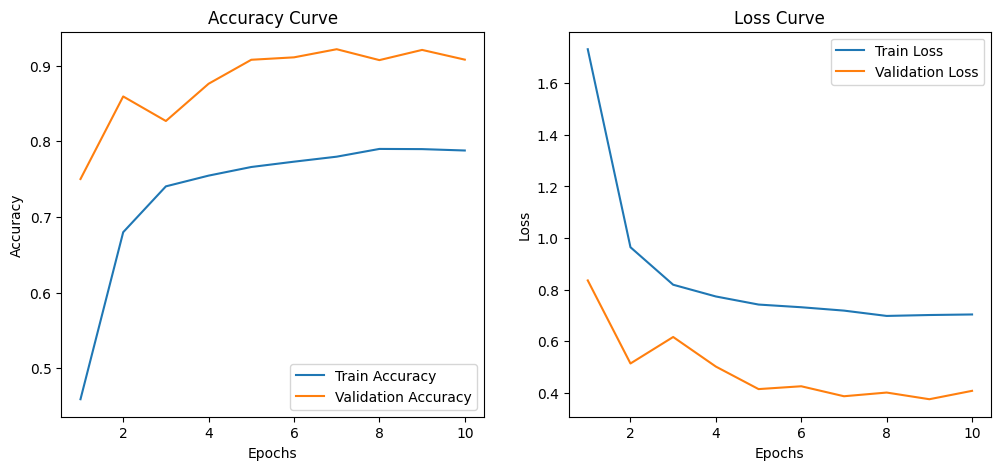

In [21]:
# Solution
# Settings
learning_rate = 0.003
epochs = 50
batch_size = 4000
validation_split = 0.2

# Create the model the model's topography.
model = create_model(layer_1_units=32, layer_2_units=10, dropout_rate=0.3)

# Train the model on the normalized training set.
history = train_model(model, train_dataset, test_dataset, 
                      epochs=10, batch_size=64, learning_rate=0.001)

plot_curve(history)

## Exercise 5: Optimize the model

Try to optimize the model, either manually or with a tuning method. At least optimize the following:
* the number of hidden layers 
* the number of nodes in each layer
* the amount of dropout layers and the dropout rate

Try to reach at least 96% accuracy against the test set.